# Project No. 2 - House Prices: Advanced Regression Techniques

## Table of Contents
* [Importing](#importing)
* [Data Preprocessing](#data_preprocessing)
    * [Preprocessing the Training Set](#preprocessing_training)
    * [Preprocessing the Validation Set](#preprocessing_validation)
    * [Feature Selection](#feature_selection)
* [Training](#training)
    * [Hyperparameter Tuning](#tuning)
        * [Random Search](#random_search)
        * [Grid Search](#grid_search)
    * [Actual Training](#actual_training)
* [Evaluation](#evaluation)
    * [Root Mean Squared Logarithmic Error](#rmse)
    * [Feature Importance](#feature_importance)
* [Submission](#submission)
    * [Preprocessing the Test Set](#preprocessing_validation)
    * [Predicting and Submitting the Predictions of The Test Set](#predict_submit)
* [Reflection](#reflection)

## Importing <a class="anchor" id="importing"></a>

This is the submission for my first Kaggle competition - House Prices: Advanced Regression Techniques (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

First, I import all the necessary libraries for my project.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from utils_house_prices import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder 

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

After importing the data provided on Kaggle, I get the log of my target variable ('SalePrice'), since the evaluation metric used by Kaggle is the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. Thus, I expect my model to perform better when training with the log of the price. I then store 'SalePrice' in a separate variable and split the data into training and validation set.

In [2]:
df = pd.read_csv('train.csv')
df['SalePrice'] = np.log1p(df['SalePrice'])
df_labels = df['SalePrice'].copy()

In [3]:
train_set, val_set, train_lab, val_lab = train_test_split(df, df_labels, random_state = 42)

I then try to get an overview on my data sets to see if their statistics are roughly the same and to ensure that the training set and validation set are similar to each other. 

In [4]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024057
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399449
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775105
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001512
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273736
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534474


In [5]:
train_set.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1095.000000,1095.000000,895.000000,1095.000000,1095.000000,1095.00000,1095.000000,1095.000000,1091.000000,1095.000000,1095.000000,1095.000000,1095.00000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1037.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,727.669406,57.118721,70.394413,10747.046575,6.129680,5.56895,1971.107763,1984.854795,103.368469,448.178082,43.790868,568.794521,1060.76347,1170.582648,354.767123,5.863927,1531.213699,0.421005,0.057534,1.578995,0.380822,2.896804,1.044749,6.564384,0.619178,1978.694311,1.784475,477.539726,96.194521,49.633790,21.118721,3.918721,15.917808,3.152511,40.529680,6.361644,2007.818265,12.031055
std,424.545069,42.624531,25.219301,11065.878057,1.366746,1.10448,30.605697,20.732472,171.644715,457.898505,153.896464,444.865511,443.87948,386.930314,440.752719,48.961376,527.197908,0.517444,0.236858,0.544976,0.496972,0.806361,0.215504,1.625103,0.644338,24.810675,0.733836,210.563755,130.396336,69.134174,61.315608,32.186042,56.844110,43.008391,328.354566,2.680894,1.325752,0.393481
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.00000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.00000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,360.500000,20.000000,59.000000,7589.000000,5.000000,5.00000,1953.500000,1966.000000,0.000000,0.000000,0.000000,221.500000,795.50000,892.000000,0.000000,0.000000,1148.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,349.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775297
50%,728.000000,50.000000,70.000000,9600.000000,6.000000,5.00000,1972.000000,1994.000000,0.000000,387.000000,0.000000,474.000000,996.00000,1096.000000,0.000000,0.000000,1478.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.013707
75%,1096.500000,70.000000,80.000000,11700.000000,7.000000,6.00000,2001.000000,2004.000000,166.000000,724.000000,0.000000,810.500000,1299.50000,1393.000000,730.500000,0.000000,1795.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.278398
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.00000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,6110.00000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000,13.521141


In [6]:
val_set.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,365.000000,365.000000,306.000000,365.000000,365.000000,365.000000,365.000000,365.000000,361.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,342.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,738.991781,56.232877,69.042484,9826.172603,6.008219,5.594521,1971.747945,1984.898630,104.642659,430.024658,54.824658,562.578082,1047.427397,1138.758904,323.668493,5.786301,1468.213699,0.438356,0.057534,1.523288,0.389041,2.775342,1.052055,6.378082,0.594521,1977.935673,1.715068,459.301370,88.394521,37.739726,24.460274,1.882192,12.490411,1.578082,52.367123,6.202740,2007.808219,12.003064
std,413.137669,41.363944,21.323922,5536.437608,1.428685,1.138716,28.996533,20.410166,207.210795,451.002628,181.758238,433.315562,423.240317,385.100746,423.338202,47.660006,518.140296,0.523783,0.244678,0.567073,0.520872,0.837937,0.234468,1.620460,0.646183,24.346387,0.785107,222.983706,108.719535,55.896054,60.540257,18.123806,52.352966,30.149218,813.899801,2.771022,1.336897,0.416693
min,16.000000,20.000000,21.000000,1491.000000,2.000000,2.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1920.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.471978
25%,375.000000,20.000000,59.000000,7332.000000,5.000000,5.000000,1954.000000,1968.000000,0.000000,0.000000,0.000000,227.000000,796.000000,864.000000,0.000000,0.000000,1069.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,301.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,11.761355
50%,745.000000,50.000000,67.500000,9098.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,360.000000,0.000000,481.000000,968.000000,1040.000000,0.000000,0.000000,1430.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,457.000000,12.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,11.951187
75%,1093.000000,70.000000,80.000000,11310.000000,7.000000,6.000000,1999.000000,2004.000000,160.000000,685.000000,0.000000,799.000000,1293.000000,1352.000000,728.000000,0.000000,1720.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.240479
max,1451.000000,190.000000,174.000000,70761.000000,10.000000,9.000000,2009.000000,2010.000000,1600.000000,2188.000000,1474.000000,2153.000000,3206.000000,2898.000000,1872.000000,514.000000,4316.000000,2.000000,2.000000,3.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2009.000000,4.000000,1390.000000,511.000000,502.000000,318.000000,238.000000,396.000000,576.000000,15500.000000,12.000000,2010.000000,13.534474


All good, so let's start preprocessing the data!

## Data Preprocessing <a class="anchor" id="data_preprocessing"></a>

### Preprocessing the Training Set <a class="anchor" id="preprocessing_training"></a>

I have a look at the training set to familiarize myself with the different features. As far as I can see, the dataset includes categorical, ordinal and numerical features.

In [7]:
train_set.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1429,1430,20,RL,NaN,12546,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,7,1981,1981,Gable,CompShg,MetalSd,MetalSd,BrkFace,310.0,Gd,Gd,CBlock,Gd,TA,No,BLQ,678,Unf,0,762,1440,GasA,Ex,Y,SBrkr,1440,0,0,1440,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1981.0,Fin,2,467,TA,TA,Y,0,0,99,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,12.116700
1206,1207,20,RH,NaN,8900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,4,4,1966,1966,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,1056,Unf,0,0,1056,GasA,TA,Y,SBrkr,1056,0,0,1056,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1966.0,Unf,1,384,TA,TA,Y,0,42,0,0,0,0,NaN,MnPrv,NaN,0,11,2006,WD,Normal,11.580593
717,718,20,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,5,6,1973,2000,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,No,BLQ,1084,Unf,0,92,1176,GasA,Gd,Y,SBrkr,1178,0,0,1178,0,1,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1973.0,Unf,2,439,TA,TA,Y,224,0,0,0,0,0,NaN,MnPrv,NaN,0,11,2008,WD,Normal,11.964007
223,224,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1971,1971,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,524,LwQ,180,160,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1989.0,Unf,2,576,TA,TA,Y,216,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Abnorml,11.482477
1185,1186,50,RL,60.0,9738,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,7,1924,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,392,Unf,0,392,784,GasA,Gd,Y,SBrkr,949,272,0,1221,1,0,1,0,4,1,TA,7,Typ,0,NaN,Attchd,1965.0,Unf,1,392,TA,TA,Y,0,0,236,0,0,0,NaN,NaN,NaN,0,3,2006,WD,Normal,11.560772
1122,1123,20,RL,NaN,8926,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,3,1956,1956,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,672,672,GasA,Ex,Y,FuseA,960,0,0,960,0,0,1,0,3,1,TA,5,Typ,0,NaN,Basment,1956.0,Unf,1,288,TA,TA,Y,64,0,0,0,160,0,NaN,MnPrv,NaN,0,10,2009,COD,Abnorml,11.626263
784,785,75,RM,35.0,6300,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,6,6,1914,2001,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,742,742,GasA,Ex,Y,SBrkr,742,742,0,1484,0,0,2,0,3,1,TA,9,Typ,1,Gd,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,291,134,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,11.759793
1126,1127,120,RL,53.0,3684,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,130.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1373,1373,GasA,Ex,Y,SBrkr,1555,0,0,1555,0,0,2,0,2,1,Gd,7,Typ,1,TA,Attchd,2007.0,Fin,3,660,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,12.066816
447,448,60,RL,NaN,11214,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1998,1999,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,930,930,GasA,Gd,Y,SBrkr,956,930,0,1886,0,0,2,1,4,1,Gd,10,Typ,1,TA,Attchd,1998.0,Fin,2,431,TA,TA,Y,89,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,12.205578
1259,1260,20,RL,65.0,9750,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,8,1969,1969,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,No

I encode the training set using the encode_dataframe funcion from utils_house_prices.py. The function:
- fills any missing categorical values with the string 'missing'
- replaces ordinal values with a numerical value (e.g. Excellent: 5, Good: 4, Regular: 3, etc.)
- fills any missing ordinal values with the mode of the respective feature
- fills any missing numerical values with the mean of the respective feature
- target-mean encodes (+ smoothes) categorical features 

In [8]:
train_set = encode_dataframe(train_set, train=True)

Let's look at the encoded dataframe to check if it was encoded correctly (the encoded columns are added to the dataframe, so scroll to the right of the dataframe to see them).

In [9]:
train_set.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded
864,865,20,FV,72.000000,8640,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1372,1372,GasA,Ex,Y,SBrkr,1372,0,0,1372,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2008.0,Fin,2,529,TA,TA,Y,0,140,0,0,0,0,NaN,missing,missing,0,5,2008,New,Partial,12.431538,12.054745,12.221268,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,12.270259,12.048364,12.031996,12.054752,12.003906,11.991663,12.027696,12.203530,12.207122,11.992610,12.04825,11.908531,12.251416,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,12.012439,12.425048,12.424477,7,5,4,3,5,3.0,1.0,1,5,4,4.0,3.0,3.0,3.0,3,1.0
304,305,75,RM,87.000000,18386,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,2003.0,Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,missing,missing,0,5,2008,WD,Normal,12.594734,12.045975,11.718196,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,11.758467,12.048364,12.031996,12.054752,12.136120,11.991663,12.027696,12.212257,12.208901,11.992610,12.04825,11.908531,11.779916,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,12.012439,11.999704,12.009189,7,9,3,3,3,3.0,1.0,1,5,4,5.0,3.0,1.0,3.0,3,1.0
280,281,60,RL,82.000000,11287,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,6,1989,1989,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,Gd,TA,CBlock,Gd,TA,Av,GLQ,421,Unf,0,386,807,GasA,Gd,Y,SBrkr,1175,807,0,1982,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1989.0,Fin,2,575,TA,TA,Y,0,84,0,196,0,0,NaN,missing,missing,0,1,2007,WD,Normal,12.339296,12.328878,12.088969,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,12.057422,12.048364,12.031996,12.054752,12.179594,11.991663,12.027696,12.054305,11.998227,12.291545,12.04825,12.148033,11.881478,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,11.985720,11.999704,12.009189,7,6,4,3,4,3.0,3.0,1,4,4,3.0,3.0,3.0,3.0,3,1.0
616,617,60,RL,70.394413,7861,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,

### Preprocessing the Validation Set <a class="anchor" id="preprocessing_validation"></a>

As I want to have the same target mean encoding for the validation set and in the training set, I encounter a problem: some categorical feature values appear in the validation set but not in the training set, so they do not have a target mean that can be mapped onto the feature values in the validation set. 

The function encode_dataframe takes the parameter train_set_categorical_encoded_means. This parameter is a dictionary with the column names of the encoded categorical features as keys and the respective target smooth meaning encoding as values. Thus, I now have to build this dictionary which I can then use as an input for the function encode_dataframe to encode the validation set. 

First, I create a dictionary (called train_val_categorical_global_means) with the all unique categorical feature values as keys and the global mean of SalePrice as values

In [11]:
train_val_categorical_global_means = {feature_encoded: 
 {feature_value: df["SalePrice"].mean() for feature_value in df[feature].unique()} 
 for feature, feature_encoded in zip(categorical_features, categorical_features_encoded)}

To explain the above cell code further:

feature_encoded: {...} creates a dictionary key for all column names of the encoded categorical features(e.g. 'Neighborhood_encoded')

{feature_value: ...} creates dictionary within the above described dictionary, which includes all unique feature values for each categorical feature (e.g. 'Veenker' for the feature 'Neighborhood_encoded') as keys

df.['SalePrice'].mean() creates a value for each key in the dictionary described above. This values is the global mean of SalePrice (value is always mean of SalePrice)

The result is a dictionary that looks something like thos: {'Neighborhood_encoded': {'Veenker': 180921.19589041095}}



Second, I create a dictionary (called train_categorical_encoded_means) with every unique categorical feature value (e.g. 'Veenker for the feature 'Neighborhood_encoded') as keys and the respective target mean (as calculated in the training set). This dictionary only includes the encoded features values of the training set. So any feature values present in the validation set, but not in the training set, do not appear in this dictionary.

In [12]:
train_categorical_encoded_means = {}

for feature, feature_encoded in zip(categorical_features, categorical_features_encoded):
    # get encoded mean of every categorical feature value and store it in mean_by_var
    mean_by_var = train_set.groupby(feature)[feature_encoded].mean().to_dict()
    # store mean_by_var as the value for every key feature_encoded in a dictionary
    train_categorical_encoded_means[feature_encoded] = mean_by_var

Third, I update the values of the first dictionary I created (train_val_categorical_global_means) with the values of the second dictionary (train_categorical_encoded_means). This means I replace the global mean of SalePrice with the target mean, but this only regards feature values that are present both in the training and validation set. Those feature values that only appear in the validation set remain unchanged (i.e. global mean).

In [13]:
# loop through keys (encoded_feature) in dict train_val_categorical_global_means
for encoded_feature in train_val_categorical_global_means.keys():
    # update the value of each key (encoded_feature) with the value of each key in train_categorical_encoded_means
    train_val_categorical_global_means[encoded_feature].update(train_categorical_encoded_means[encoded_feature])
# this dictionary can now be used to encode the validation set with the encode_dataframe() function below

The dictionary train_val_categorical_global_means can now be used as a parameter for the function encode_dataframe to encode the validation set. 

In [14]:
val_set = encode_dataframe(val_set, train=False, 
                           train_set_categorical_encoded_means=train_val_categorical_global_means)

Let's see if encoding the validation set worked correctly (scroll to the right of the dataframe again).

In [15]:
val_set.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded
1006,1007,20,RL,69.042484,12155,Pave,missing,IR3,Lvl,AllPub,Inside,Gtl,NAmes,PosN,Norm,1Fam,1Story,6,3,1970,1970,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,LwQ,1237,Unf,0,420,1657,GasA,Gd,Y,SBrkr,1657,0,0,1657,0,1,2,0,3,1,TA,7,Typ,1,TA,Attchd,1970.0,Unf,2,484,TA,TA,Y,0,0,0,0,147,0,NaN,missing,missing,0,3,2007,WD,Normal,12.004574,12.054745,12.088969,12.031378,12.045366,12.121899,12.031056,12.0312,12.011700,12.027223,11.887648,12.180588,12.032,12.054752,12.003906,11.9917,12.0277,12.0543,11.9982,11.891820,12.048250,11.908531,11.881478,12.0388,12.0651,12.0477,12.161726,12.064360,12.035123,12.014293,11.999704,12.009189,6,3,3,3,4,3.0,1.0,1,4,3,3.0,3.0,1.0,3.0,3,3
1428,1429,30,RM,60.000000,7200,Pave,missing,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,7,1940,1992,Gable,CompShg,MetalSd,MetalSd,Stone,294.0,TA,Gd,CBlock,TA,TA,No,BLQ,510,Unf,0,278,788,GasA,TA,Y,SBrkr,804,0,0,804,1,0,1,0,2,1,Gd,4,Typ,2,Gd,Attchd,1940.0,Unf,1,240,TA,TA,Y,0,0,154,0,0,0,NaN,MnPrv,missing,0,2,2010,WD,Abnorml,11.686887,11.537206,11.718196,12.031378,12.045366,11.948454,12.031056,12.0312,12.012909,12.027223,11.758467,12.048364,12.032,12.054752,12.003906,11.9917,12.0277,11.8726,11.8744,11.891092,12.048250,12.381494,11.881478,12.0388,12.0651,12.0477,12.161726,11.890665,12.035123,12.041196,11.999704,11.840915,5,7,3,4,3,3.0,1.0,1,3,4,4.0,3.0,1.0,3.0,3,3
695,696,20,RL,54.000000,13811,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,6,6,1987,1987,Gable,CompShg,HdBoard,HdBoard,BrkFace,72.0,TA,TA,CBlock,Gd,Gd,No,GLQ,980,LwQ,40,92,1112,GasA,Gd,Y,SBrkr,1137,0,0,1137,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.0,Unf,2,551,TA,TA,Y,125,0,0,0,0,0,NaN,missing,missing,0,7,2006,WD,Normal,12.078245,12.054745,12.088969,12.031378,12.045366,12.149293,12.031056,12.0312,12.011700,12.027223,12.261478,12.048364,12.032,12.054752,12.003906,11.9917,12.0277,11.9461,11.9655,12.291545,11.979286,12.148033,11.881478,12.0388,12.0651,12.0477,12.161726,12.064360,12.035123,12.066630,11.999704,12.009189,6,6,3,3,4,4.0,1.0,1,4,4,3.0,3.0,1.0,3.0,3,3
1327,1328,20,RL,60.000000,6600,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,9,1982,2008,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,Gd,CBlock,TA,TA,No,ALQ,641,Unf,0,175,816,GasA,Ex,Y,SBrkr,816,0,0,81

### Feature Selection <a class="anchor" id="feature_selection"></a>

Both the training and validation set now have a column for each encoded categorical and ordinal feature, alongside with the original columns for the categorical and ordinal features. Since I only care about the encoded features, I select those and store them in a new dataframe, together with all numerical features.

In [16]:
train_set_selected_features = train_set[categorical_features_encoded + ordinal_features_encoded + numerical_features]
val_set_selected_features = val_set[categorical_features_encoded + ordinal_features_encoded + numerical_features]

Finally, I convert all columns to numeric

In [17]:
train_set_selected_features = train_set_selected_features.apply(pd.to_numeric)
val_set_selected_features = val_set_selected_features.apply(pd.to_numeric)

Here are the preprocessed training and validation set in their final version:

In [18]:
train_set_selected_features.sample(5)

,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
14,12.054745,12.088969,12.031378,12.045366,12.149293,12.031056,12.031236,12.012909,12.027223,11.887648,12.048364,12.031996,12.054752,12.003906,12.173504,12.027696,11.872562,11.874391,11.891092,12.04825,12.148033,11.881478,12.038822,12.065112,12.047687,12.161726,11.81509,12.035123,12.012439,11.999704,12.009189,6,5,3,3,3,3.0,1.0,1,3,3,2.0,3.0,2.0,3.0,3,1.0,70.394413,10920,1960,1960,212.0,733,0,520,1253,1253,0,0,1253,1,0,1,1,2,1,5,1,1960.0,1,352,0,213,176,0,0,0,0,2008
225,11.842866,11.718196,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,11.738745,12.048364,12.031996,11.839082,12.179594,11.991663,12.027696,11.946118,11.965539,11.992610,12.04825,12.148033,11.881478,12.038822,12.065112,12.047687,11.790778,12.06436,12.035123,12.012439,11.846164,11.840915,5,5,3,3,3,3.0,1.0,1,3,3,4.0,3.0,1.0,3.0,3,1.0,21.000000,1680,1971,1971,142.0,0,0,630,630,630,672,0,1302,0,0,2,1,3,1,6,0,1991.0,1,280,0,0,0,0,0,0,0,2009
1248,12.045975,11.718196,12.031378,11.755999,11.948454,12.031056,12.031236,12.011700,12.027223,11.758467,12.048364,12.031996,12.054752,11.930765,11.991663,12.027696,11.760650,11.794184,11.876196,12.04825,11.908531,11.779916,11.982815,12.065112,12.047687,11.790778,12.06436,12.035123,11.990942,11.999704,12.009189,6,5,3,3,4,3.0,1.0,0,2,3,4.0,2.0,1.0,2.0,2,1.0,60.000000,9600,1917,1950,0.0,319,0,416,735,1134,924,0,2058,0,0,1,1,3,1,8,1,1950.0,2,396,0,0,259,0,0,0,0,2008
864,12.054745,12.221268,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,12.270259,12.048364,12.031996,12.054752,12.003906,11.991663,12.027696,12.203530,12.207122,11.992610,12.04825,11.908531,12.251416,12.038822,12.065112,12.047687,12.161726,12.06436,12.035123,12.012439,12.425048,12.424477,7,5,4,3,5,3.0,1.0,1,5,4,4.0,3.0,3.0,3.0,3,1.0,72.000000,8640,2007,2008,0.0,0,0,1372,1372,1372,0,0,1372,0,0,2,0,3,1,6,0,2008.0,2,529,0,140,0,0,0,0,0,2008
712,12.161543,12.088969,12.031378,12.045366,12.149293,12.247351,12.031236,12.011700,12.027223,12.387759,12.048364,12.031996,12.071950,12.003906,11.991663,12.027696,11.946118,11.965539,12.291545,12.04825,11.908531,12.251416,12.038822,12.065112,12.047687,12.161726,12.06436,12.035123,12.013028,11.999704,12.009189,8,5,4,3,4,3.0,2.0,1,4,4,4.0,3.0,3.0,3.0,3,1.0,40.000000,4671,1988,1989,0.0,767,0,461,1228,1228,0,0,1228,1,0,2,0,2,1,5,1,1988.0,2,472,168,120,0,0,0,0,0,2008


In [19]:
val_set_selected_features.sample(5)

,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
31,12.054745,12.088969,12.031378,12.045366,12.149293,12.031056,12.031236,12.238062,12.027223,11.844165,12.048364,12.031996,12.054752,12.003906,11.991663,12.027696,11.946118,11.965539,11.992610,12.048250,11.908531,11.881478,12.038822,12.065112,12.047687,12.161726,11.890665,12.035123,12.017538,11.999704,12.009189,5,6,3,3,3,3.0,1.0,1,4,4,4.0,3.0,1.0,3.0,3,3,69.042484,8544,1966,2006,0.0,0,0,1228,1228,1228,0,0,1228,0,0,1,1,3,1,6,0,1966.0,1,271,0,65,0,0,0,0,0,2008
420,11.834028,11.718196,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,11.959149,12.048364,12.031996,11.834028,11.883045,11.991663,12.027696,12.203530,12.207122,12.291545,12.048250,12.148033,12.251416,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,12.069196,11.999704,12.085223,7,5,3,4,4,4.0,4.0,1,5,3,4.0,3.0,3.0,3.0,3,3,78.000000,7060,1997,1998,200.0,1309,0,35,1344,1344,0,0,1344,2,0,2,0,2,2,8,0,1997.0,4,784,0,0,0,0,0,0,0,2008
208,12.328878,12.088969,12.031378,12.045366,12.149293,12.082516,12.031236,12.011700,12.068783,12.057422,12.048364,12.031996,12.054752,12.179594,11.991663,12.027696,12.054305,11.998227,12.291545,12.048250,12.148033,11.881478,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,11.990942,11.999704,12.009189,7,5,4,3,4,3.0,4.0,1,5,3,4.0,3.0,3.0,3.0,3,3,69.042484,14364,1988,1989,128.0,1065,0,92,1157,1180,882,0,2062,1,0,2,1,3,1,7,1,1988.0,2,454,60,55,0,0,154,0,0,2007
522,11.825334,11.718196,12.031378,12.045366,11.948454,12.031056,12.031236,12.012909,12.027223,11.727936,11.855844,12.031996,12.054752,11.825472,11.991663,12.027696,12.212257,12.208901,11.952321,12.048250,11.908531,11.881478,12.038822,12.065112,12.047687,11.790778,12.064360,12.035123,12.013028,11.999704,12.009189,6,7,3,4,3,3.0,1.0,1,5,3,4.0,3.0,1.0,3.0,3,3,50.000000,5000,1947,1950,0.0,399,0,605,1004,1004,660,0,1664,0,0,2,0,3,1,7,2,1950.0,2,420,0,24,36,0,0,0,0,2006
1220,12.054745,12.088969,12.031378,12.045366,12.149293,12.031056,12.031236,12.011700,12.027223,11.887648,12.048364,12.031996,12.054752,12.003906,11.991663,12.027696,11.849029,11.862926,11.876196,11.979286,11.908531,11.881478,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,12.069196,11.999704,11.840915,5,5,3,3,3,3.0,1.0,1,3,3,4.0,3.0,1.0,3.0,3,3,66.000000,7800,1964,1964,0.0,312,600,0,912,912,0,0,912,0,0,1,0,2,1,5,0,1964.0,1,288,0,0,0,0,0,0,0,2006


## Training <a class="anchor" id="training"></a>

Since I wanted to practice using Random Forest in this challenge and get to know the model's hyperparameters in depth, I used Random Search and Grid Search to get the best hyperparameters for my RandomForest model.

### Hyperparameter Tuning <a class="anchor" id="tuning"></a>

#### Random Search <a class="anchor" id="random_search"></a>

First, I set the hyperparameters (max_depth, max_features, min_samples_leaf, min_samples_split, and n_estimators) to a list of values I selected manually and build the hyperparameter grid.

In [23]:
max_depth = [3, 5, 10, 25, 35, 50]
max_features = ['auto', 'sqrt', 'log2', 3, 5, 10, 15]
min_samples_leaf = [2, 5, 10, 15, 20]
min_samples_split = [2, 5, 10, 15]
n_estimators = [100, 200, 300, 500, 800, 1000]

In [24]:
param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

I then instantiate the Random Forest Regressor and the Random Search, and I call .fit on the Random Search object to find the best hyperparameters from the ones I manually selected.

In [29]:
rf = RandomForestRegressor()

In [30]:
rf_random = RandomizedSearchCV(estimator = rf,
                              param_distributions = param_grid,
                              # number of random parameter combinations that are tried out
                              n_iter = 100,
                              cv = 5,
                              # print messages while running
                              verbose = 2,
                              # use all available processors
                              n_jobs = -1)

In [31]:
rf_random.fit(train_set_selected_features, train_lab)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/Helene/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 33.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True], 'max_depth': [40, 50, 60], 'max_features': ['auto'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [4, 5, 6], 'n_estimators': [900, 1000, 1100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [36]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

#### Grid Search <a class="anchor" id="grid_search"></a>

In order to find even better hyperparameters, I now take the ones from Random Search as the basis to set each hyperparameters to a list of values that have a more narrow range than before.

In [40]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 4, 5, 6],
    'n_estimators': [800, 900, 1000]
}

I instantiate GridSearch and call .fit on the object to run the search.

In [41]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)

In [42]:
grid_search.fit(train_set_selected_features, train_lab)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True], 'max_depth': [40, 50, 60], 'max_features': ['auto'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [3, 4, 5, 6], 'n_estimators': [800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1000}

I save the best hyperparameters in a separate variable to use them in my Random Forest model below.

In [44]:
best_grid = grid_search.best_estimator_

### Actual training <a class="anchor" id="actual_training"></a>

I now instantiate RandomForestRegressor with the hyperparameters saved above and fit the model, using the preprocessed training set and the training labels.

In [48]:
model = RandomForestRegressor(
    bootstrap = True, 
    max_depth = 60, 
    max_features = 'auto', 
    min_samples_leaf = 1, 
    min_samples_split = 4, 
    n_estimators = 1000 , 
    n_jobs = -1)

In [49]:
model.fit(train_set_selected_features, train_lab)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Evaluation <a class="anchor" id="evaluation"></a>

To evaluate my model, I use the preprocessed validation set and call .predict on it.

In [50]:
preds = model.predict(val_set_selected_features)

Now I want to get a first glimpse of the model's performance. Since so far I used the log of SalePrice, I now convert the predicted values as well as the validation labels back to how they were originally. Then I look at the first 15 prices of both the predictions as well as of the actual prices to compare them with each other

In [105]:
preds_exp = np.expm1(preds).round(0)
val_lab_exp = np.expm1(val_lab)

In [106]:
preds_list = preds_exp.tolist()
val_lab_list = val_lab_exp.tolist()

In [144]:
evaluation = pd.DataFrame(list(zip(preds_list, val_lab_list)), columns =['Predicted_Price', 'Actual_Price'])
evaluation['Difference'] = evaluation.apply(lambda row: row.Predicted_Price - row.Actual_Price, axis = 1)
evaluation.head(15)

,Predicted_Price,Actual_Price,Difference
0,140354.0,154500.0,-14146.0
1,318052.0,325000.0,-6948.0
2,113241.0,115000.0,-1759.0
3,144670.0,159000.0,-14330.0
4,307090.0,315500.0,-8410.0
5,83273.0,75500.0,7773.0
6,199986.0,311500.0,-111514.0
7,149497.0,146000.0,3497.0
8,81669.0,84500.0,-2831.0
9,126980.0,135500.0,-8520.0


### Root Mean Squared Logarithmic Error (RMSLE) <a class="anchor" id="rmse"></a>

To get the precise performance of my model, I use the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

In [115]:
mean_squared_log_error(val_lab_exp, preds_exp)**0.5

0.13463426135655818

### Feature Importance <a class="anchor" id="feature_importance"></a>

To learn about the feature importance of my model, I want to plot them using a horizontal bar plot and have a look at the twenty most important features.

In [116]:
features = numerical_features + categorical_features_encoded + ordinal_features_encoded
y_values = []
x_values = []

# loops through the indices of model.feature_importances, sorted in descending order 
for i in np.argsort(model.feature_importances_)[::-1][:20][::-1]:
    # adds the name of the feature to the list x_values
    x_values.append(features[i])
    # adds the importance of the features to the list y_values
    y_values.append(model.feature_importances_[i])

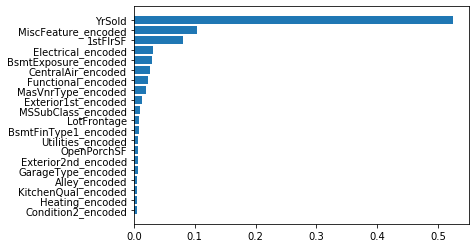

In [117]:
fig, ax = plt.subplots()
y_pos = range(len(y_values))
ax.barh(y_pos, y_values)
ax.set_yticks(y_pos)
ax.set_yticklabels(x_values)
plt.show()

This tells me that the year in which a house is sold is by far the most important feature, followed by any miscellaneous features and the number of square feet of the first floor.

## Submission <a class="anchor" id="submission"></a>

In order to submit my predictions to Kaggle, I load the test set and have a look at it.

In [118]:
test_set = pd.read_csv('test.csv')

In [119]:
test_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Preprocessing the Test Set <a class="anchor" id="preprocessing_test"></a>

In order to use the test set as an input for my model, I process and encode it the same way I did with the validation set. As I did with the validation set, I use the dictionary train_val_categorical_global_means as a parameter for the function encode_dataframe. As a reminder: this dictionary with the column names of the encoded categorical features as keys and the respective target smooth meaning encoding as values.

In [120]:
test_set = encode_dataframe(test_set, train=False, 
                           train_set_categorical_encoded_means=train_val_categorical_global_means)

Let's have a look at the encoded test set:

In [121]:
test_set.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded
847,2308,120,RL,34.000000,4590,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,8,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,108.0,Gd,TA,PConc,Gd,Gd,Mn,GLQ,24.0,Unf,0.0,1530.0,1554.0,GasA,Ex,Y,SBrkr,1554,0,0,1554,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2006.0,RFn,2.0,627.0,TA,TA,Y,156,73,0,0,0,0,NaN,missing,missing,0,5,2007,CWD,Normal,12.161543,12.089,12.031378,12.045366,11.948454,12.031056,12.0312,12.011700,12.027223,12.519582,12.048364,12.032,11.839082,12.0039,11.991663,12.0277,12.2035,12.2071,12.291545,12.04825,12.381494,12.251416,12.0388,12.0651,12.0477,12.161726,12.06436,12.035123,12.012439,12.0789,12.009189,8,5,4,3,4,4.0,2.0,1,5,4,4.0,3.0,2.0,3.0,3,4
331,1792,20,RL,83.000000,10143,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1963,1963,Gable,CompShg,HdBoard,HdBoard,BrkFace,295.0,TA,TA,CBlock,TA,TA,No,Rec,384.0,Unf,0.0,996.0,1380.0,GasA,Fa,Y,SBrkr,1380,0,0,1380,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1963.0,Unf,1.0,364.0,TA,TA,Y,0,0,0,0,216,0,NaN,GdWo,missing,0,6,2009,WD,Normal,12.054745,12.089,12.031378,12.045366,11.948454,12.031056,12.0312,12.011700,12.027223,11.887648,12.048364,12.032,12.054752,12.0039,11.991663,12.0277,11.9461,11.9655,11.876196,12.04825,12.148033,11.881478,12.0388,12.0651,12.0477,12.161726,11.81509,12.035123,12.017538,11.9997,12.009189,6,7,3,3,3,3.0,1.0,1,2,3,4.0,3.0,1.0,3.0,3,4
485,1946,20,RL,68.580357,31220,Pave,missing,IR1,Bnk,missing,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NaN,missing,Shed,750,5,2008,WD,Normal,12.054745,12.089,12.031378,12.045366,12.149293,11.832181,missing,12.026701,12.027223,12.155763,11.855844,12.032,12.054752,12.0039,12.173504,12.0277,12.1292,12.1571,11.992610,12.04825,11.908531,11.881478,12.0388,11.7422,11.8828,12.161726,12.06436,11.956539,12.012439,11.9997,12.009189,6,2,3,3,3,3.0,1.0,1,3,3,4.0,3.0,1.0,3.0,3,4
785,2246,20,RL,68.580357,17979,Pave,missing,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,6,1968,1968,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,No,ALQ,785.0,Unf,0.0,328.0,1113.0,GasA,Ex,Y,SBrkr,1160,0,0,1160

Again, since I only want to use the encoded version of the categorical and ordinal features, I store them in a new dataframe.

In [122]:
test_set_selected_features = test_set[categorical_features_encoded + ordinal_features_encoded + numerical_features]

Similar to the problem I had when encoding the validation set, the problem when encoding the test set is that some categorical feature values appear in the test set but neither in the training nor validation set, so they
do not have a target mean that can be mapped onto the feature values in the test set. 

To solve this problem, first, I find out which categorical feature values appear in the test set but not in the training and validation set. To do so, I loop through all categorical features and create two lists (train_set_feature_values, val_set_feature_values and test_set_feature_values) that include the values of every categorical feature of the training, validation, and test set, respectively. I then compare these three lists to each other (looping through every value in test_set_feature_values). If any value is included in the test set but not in the training or validation set, I append both the value and its corresponding feature name to two lists.

In [123]:
unique_features = []
unique_feature_values = []

for feature in categorical_features:
    
    train_set_feature_values = train_set[feature].value_counts().index.tolist()
    val_set_feature_values = val_set[feature].value_counts().index.tolist()
    test_set_feature_values = test_set[feature].value_counts().index.tolist()
    
    train_val_set_feature_values = train_set_feature_values + val_set_feature_values
    
    for value in test_set_feature_values:
        if not value in train_val_set_feature_values:
            unique_features.append(feature)
            unique_feature_values.append(value)
            
print(unique_features)
print(unique_feature_values)

['MSSubClass', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Functional', 'SaleType']
[150, 'missing', 'missing', 'missing', 'missing', 'missing', 'missing']


Second, I replace the categorical feature values which only appear in the test set with the global SalePrice mean. To do so, I create a list of those feature names (called unique_features_encoded) that include values which only appear in the test set. I then loop through these feature names, create a new dictionary (called test_categorical_encoding), which includes the unique feature names as keys and an embedded dictionary as values. Within these embedded dictionaries, I store the unqique feature values (as keys) and the global mean of SalePrice (as values). I then use this two-layer dictionary (test_categorical_encoding) to replace the final non-encoded categorical feature values in the test set. Finally, I convert all columns to numeric.

In [126]:
unique_features_encoded = [feature + '_encoded' for feature in unique_features]

for i in range(len(unique_features)):
    test_categorical_encoding = {}
    test_categorical_encoding[unique_features_encoded[i]] = {}
    test_categorical_encoding[unique_features_encoded[i]][unique_feature_values[i]] = train_set.SalePrice.mean()
    test_set_selected_features = test_set_selected_features.replace(test_categorical_encoding)

In [127]:
test_set_selected_features = test_set_selected_features.apply(pd.to_numeric)

In [128]:
test_set_selected_features.sample(5)

,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
1363,12.028835,12.088969,12.031378,12.045366,12.149293,12.031056,12.031236,12.011700,12.027223,11.754418,12.048364,12.031996,12.054752,12.006707,11.991663,12.027696,12.054305,11.998227,11.952321,11.994108,12.381494,11.881478,12.038822,12.065112,11.882776,12.161726,11.890665,12.035123,12.012439,11.999704,12.009189,5,5,3,3,3,3.0,4.0,1,5,3,2.0,3.0,3.0,3.0,3,4,78.0,11679,1962,1962,96.0,612.0,1164.0,0.0,1776.0,1560,0,0,1560,0.0,1.0,2,0,3,1,6,1,1962.0,2.0,528.0,453,253,144,0,0,0,0,2006
1259,12.054745,12.088969,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,12.118698,12.118591,12.031996,12.054752,12.003906,12.173504,12.027696,11.946118,11.965539,11.891092,11.979286,12.148033,11.881478,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,11.990942,11.999704,12.009189,7,6,3,3,3,3.0,1.0,1,4,3,4.0,3.0,2.0,3.0,3,4,78.0,10140,1967,1967,264.0,553.0,68.0,713.0,1334.0,1334,0,0,1334,1.0,0.0,2,0,3,1,7,0,1967.0,2.0,477.0,0,20,35,0,264,0,0,2006
764,11.834028,12.088969,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,11.959149,12.048364,12.031996,11.834028,12.179594,11.991663,12.027696,12.054305,11.998227,11.655984,11.655984,11.908531,11.881478,12.038822,12.065112,12.047687,12.161726,12.064360,12.035123,12.069196,11.999704,11.840915,5,4,3,3,3,3.0,1.0,1,3,3,4.0,3.0,1.0,3.0,3,4,76.0,10260,1976,1976,0.0,0.0,0.0,0.0,0.0,936,936,0,1872,0.0,0.0,2,2,4,2,8,0,1976.0,2.0,484.0,0,0,0,0,0,0,0,2008
964,12.005893,12.088969,12.031378,12.045366,11.948454,12.031056,12.031236,12.011700,12.027223,11.887648,12.048364,12.031996,12.054752,12.179594,11.991663,12.027696,11.849029,11.874391,11.992610,12.048250,11.908531,11.779916,12.038822,12.065112,11.909109,12.321949,12.064360,12.035123,12.069196,11.999704,11.932075,5,4,3,3,3,2.0,1.0,1,4,4,4.0,3.0,1.0,3.0,3,4,113.0,21281,1935,2007,0.0,0.0,0.0,666.0,666.0,1308,1778,0,3086,0.0,0.0,3,1,4,1,9,0,2007.0,3.0,1200.0,0,208,290,0,156,0,0,2007
106,11.537206,12.088969,12.031378,12.045366,11.948454,12.031056,12.031236,12.012909,12.027223,11.844165,11.855844,12.031996,12.054752,12.003906,11.991663,12.027696,11.849029,11.862926,11.992610,12.048250,11.908531,11.779916,12.038822,12.065112,12.047687,11.790778,12.064360,12.035123,12.017538,11.999704,12.009189,4,4,3,3,2,3.0,1.0,0,3,3,4.0,3.0,1.0,3.0,1,4,94.0,9259,1927,1950,0.0,0.0,0.0,660.0,660.0,756,0,0,756,0.0,0.0,1,0,2,1,4,0,1945.0,2.0,440.0,80,0,0,0,0,0,0,2010


### Predicting and Submitting the Predictions of The Test Set <a class="anchor" id="predict_submit"></a>

To apply my model to the test set, I call .predict on it and store the predictions in a variable called preds_submission, add it as a new column to the test set and get the exponentials of the predictions, since they are still in logarithmic form.

In [129]:
preds_submission = model.predict(test_set_selected_features)
test_set['SalePrice'] = preds_submission
test_set['SalePrice'] = np.expm1(test_set['SalePrice'])

In [130]:
test_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSSubClass_encoded,MSZoning_encoded,Street_encoded,Alley_encoded,LotShape_encoded,LandContour_encoded,Utilities_encoded,LotConfig_encoded,LandSlope_encoded,Neighborhood_encoded,Condition1_encoded,Condition2_encoded,BldgType_encoded,HouseStyle_encoded,RoofStyle_encoded,RoofMatl_encoded,Exterior1st_encoded,Exterior2nd_encoded,BsmtFinType1_encoded,BsmtFinType2_encoded,MasVnrType_encoded,Foundation_encoded,Heating_encoded,Electrical_encoded,Functional_encoded,GarageType_encoded,Fence_encoded,MiscFeature_encoded,MoSold_encoded,SaleType_encoded,SaleCondition_encoded,OverallQual_encoded,OverallCond_encoded,ExterQual_encoded,ExterCond_encoded,BsmtQual_encoded,BsmtCond_encoded,BsmtExposure_encoded,CentralAir_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageQual_encoded,GarageFinish_encoded,GarageCond_encoded,PavedDrive_encoded,PoolQC_encoded,SalePrice
0,1461,20,RH,80.0,11622,Pave,missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,missing,0,6,2010,WD,Normal,12.054745,11.8553,12.031378,12.045366,11.948454,12.031056,12.0312,12.011700,12.027223,11.887648,11.855844,12.032,12.054752,12.0039,11.991663,12.0277,12.2035,12.2071,11.876196,11.979286,11.908531,11.881478,12.0388,12.0651,12.0477,12.161726,11.890665,12.035123,12.017538,11.9997,12.009189,5,6,3,3,3,3.0,1.0,1,3,3,4.0,3.0,1.0,3.0,3,4,124201.118652
1,1462,20,RL,81.0,14267,Pave,missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,missing,Gar2,12500,6,2010,WD,Normal,12.054745,12.089,12.031378,12.045366,12.149293,12.031056,12.0312,12.012909,12.027223,11.887648,12.048364,12.032,12.054752,12.0039,12.173504,12.0277,11.849,11.8629,11.952321,12.048250,12.148033,11.881478,12.0388,12.0651,12.0477,12.161726,12.064360,12.042303,12.017538,11.9997,12.009189,6,6,3,3,3,3.0,1.0,1,3,4,4.0,3.0,1.0,3.0,3,4,152660.739717
2,1463,60,RL,74.0,13830,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,missing,0,3,2010,WD,Normal,12.328878,12.089,12.031378,12.045366,12.149293,12.031056,12.0312,12.011700,12.027223,12.155763,12.048364,12.032,12.054752,12.1796,11.991663,12.0277,12.2035,12.2071,12.291545,12.048250,11.908531,12.251416,12.0388,12.0651,12.0477,12.161726,11.890665,12.035123,12.014293,11.9997,12.009189,5,5,3,3,4,3.0,1.0,1,4,3,3.0,3.0,3.0,3.0,3,4,191473.706901
3,1464,60,RL,78.0,9978,Pave,missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0

I then create a dataframe that only includes the index as well as the predicted house prices (which is the required format to submit on Kaggle) and save it.

In [131]:
submission = test_set[['Id', 'SalePrice']]
submission.head()

,Id,SalePrice
0,1461,124201.118652
1,1462,152660.739717
2,1463,191473.706901
3,1464,187378.551544
4,1465,201449.183472


In [138]:
submission.to_csv (r'/Users/Helene/desktop/house_prices_sub.csv', index = False, header=True)